# Advanced Multistep Reasoning

In [22]:
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from dotenv import load_dotenv

load_dotenv()

True

### Function to Retrieve a bible text from api and combine it as one text chunk

In [23]:
import requests
import re

## get bible passage from https://bible-api and return a string version of the bible

def bible_text(passage: str) -> str:
    """
    Fetches a Bible passage from Bible-API and returns it in a formatted string:
    Example: "Luke 15:1-2 1. Text 2. Text"
    """
    url = f"https://bible-api.com/{passage.replace(' ', '%20')}?translation=kjv"
    response = requests.get(url)
    
    if response.status_code != 200:
        return f"Error fetching passage: {response.status_code}"

    data = response.json()
    reference = data.get("reference", "")
    verses = data.get("verses", [])
    
    merged_verses = " ".join(
        [f'{v["verse"]}. {v["text"].strip()}' for v in verses]
    )
    final_text = f"{reference} {merged_verses}"
    cleaned_text =re.sub(r'\s+', ' ', final_text).strip()

    return cleaned_text



### Retrieve the text using the bible_text function and store it as a list of Documents

In [24]:
docs =[
Document(page_content=bible_text("Luke 15"), metadata={"source":"Luke 15"}),
Document(page_content=bible_text("Psalm 1"), metadata={"source":"Psalm 1"}),
Document(page_content=bible_text("Psalm 124"), metadata={"source":"Psalm 124"}),
Document(page_content=bible_text("Psalm 2"), metadata={"source":"Psalm 2"}),

] 


### Create Embedding (OpenAIEmbeddings), chroma db (Chroma.from_documents) and retriever (db.as_retriever)

In [25]:
embedding_function = OpenAIEmbeddings()
db = Chroma.from_documents(docs, embedding_function)
retriever =db.as_retriever(search_type="mmr", search_kwargs={"k":3})

### NEW implementation - Tools Declaration there

In [26]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

llm =ChatOpenAI(model="gpt-4o")

template = """
Answer the question based on the followin context and the Chathistory. Especially take the latest quesiton into considerations:

Chathistory: {history}

Context: {context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

rag_chain = prompt | llm

### Instantiate AgentState as Typedict 

In [76]:
from typing import Sequence, Annotated, Literal, TypedDict, List 
from langgraph.graph import StateGraph, END, add_messages
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage, AIMessage
from pydantic import BaseModel, Field

class AgentState(TypedDict):
    question: HumanMessage   # original question
    messages: List[BaseMessage] # combination of all generated messages
    documents: List[Document]  # list of generated documetn -  the document chunks retrieved
    on_topic: str    # is the question on topic
    rephrased_question: str # rephrased question here - if original question not robust, question is rephrased
    proceed_to_generate: bool # if answer is found, then go and generate answer
    rephrase_count: int # number of time question have been rephrased. if total exceeded then end


class GradeQuestion(BaseModel):
    score: str =Field(description="Question is not about the specified topic? if yes -> 'Yes' if no-> 'No'")


def question_rewriter(state:AgentState):
    print(f"Entering question_rewriter with the following state:{state}")

    # reset state variables except for 'question' and 'message'
    state["documents"] = []
    state["on_topic"] = ""
    state["rephrased_question"] = ""
    state["proceed_to_generate"] = False
    state["rephrased_count"] = 0

    if "messages" not in state or state["messages"] is None:
        state["messages"]=[]

    if state["question"] not in state["messages"]:
        state["messages"].append(state["question"])

    if len(state["messages"]) > 1:
        conversation = state["messages"][-1]
        current_question = state["question"].content
        messages = [
            SystemMessage(
                content = """You are a helpful assistnat that rephrases the user's question to be 
                            a standalone question optimized for retrieval.
                            """
            )
        ]

        messages.extend(conversation)
        messages.append(HumanMessage(content=current_question))
        rephrase_prompt = ChatPromptTemplate.from_messages(messages)
        # rephrase_prompt = ChatPromptTemplate.from_template(messages)
        llm = ChatOpenAI(model="gpt-4o-mini")
        prompt = rephrase_prompt.format()
        response = llm.invoke(prompt)
        better_question = response.content.strip()
        print(f"Question_rewwriter: Rephrased Question:{better_question}")
        state["rephrased_question"] =better_question
    else:
        state["rephrased_question"] = state["question"].content

    return state


def question_classifier(state:AgentState):
    print("Entering Question_classifier")
    system_message= SystemMessage(
        content= """You are a classifier that determines whether a user's question is about bible related topics
        If topic is about bible respond with 'Yes' otherwise respond with 'No'
        """
    )

    human_message = HumanMessage(content=f"User Question {state['rephrased_question']}") 
    grade_prompt = ChatPromptTemplate.from_messages(
        [
            system_message,
            human_message
        ]
    )
    llm = ChatOpenAI(model="gpt-4o")
    structured_llm = llm.with_structured_output(GradeQuestion)
    grader_llm = grade_prompt | structured_llm
    result = grader_llm.invoke({})
    state["on_topic"] = result.score.strip()
    print(f"question_classifier: on_topic = {state['on_topic']}")
    return state

def on_topic_router(state:AgentState):
    print("Entering on_topic_router")
    on_topic = state.get("on_topic","").strip().lower()
    if on_topic =="yes":
        print("Routing to retrieve")
        return "retrieve"
    else:
        print("Routing to off_topic_response")
        return "off_topic_response"

def retrieve(state:AgentState):
    print("Entering retrieve")
    # print(f"\tCurrent State {state}")
    documents = retriever.invoke(state["rephrased_question"])
    # print("\t...document created")
    print(f"retrieve: Retrieve {len(documents)} documents")
    state["documents"] = documents
    return state

#structured output definition for retriever_grader
class GradeDocument(BaseModel):
    score: str = Field(description="document is relevant to the quesiton? If yest-> 'Yes' if not -> 'No' ")
    
def retriever_grader(state:AgentState):
    print("Entering retrieval_grader")
    system_message = SystemMessage(
        content = """You are a grader assessing the relevance of a retrieved document to a user question
        Only answer with 'Yes' or 'No'

        If the document contains information relevant to the user's question, respond with 'Yes', otherwise, respond with 'No'
        """
    )

    llm = ChatOpenAI(model="gpt-4o")
    structured_llm = llm.with_structured_output(GradeDocument)

    relevant_docs = []
    for doc in state["documents"]:
        human_message = HumanMessage(
            content=f"User question: {state['rephrased_question']}\n\nRetrieved document:\n{doc.page_content}"
        )
        grade_prompt = ChatPromptTemplate.from_messages(
            [
                system_message,
                human_message
            ]
        )
        grader_llm = grade_prompt | structured_llm
        result = grader_llm.invoke({})
        print(f"Grading document {doc.page_content[:30]}... Result: {result.score.strip()}")

        if result.score.strip().lower()=="yes":
            relevant_docs.append(doc)
    state["documents"] = relevant_docs
    state["proceed_to_generate"] = len(relevant_docs) > 0
    print(f"retrieval_grader: proceed_to_generate = {state['proceed_to_generate']}")
    return state

def proceed_router(state:AgentState):
    print("Entering Proceed_router")
    rephrase_count = state.get("rephrase_count",0)
    if state.get("proceed_to_generate", False):
        print("Routing to generate_answer")
        return "generate_answer"
    elif rephrase_count >=2:
        print("Maximum rephrase attempts reach. Cannot find  documents")
        return "cannot_answer"
    else:
        print("Routing to refine_question")
        return "refine_question"

def refine_question(state:AgentState):
    print("Entering refine_question")
    rephrase_count = state.get("rephrase_count",0)
    if rephrase_count >= 2:
        print("Maximun rephrase attempts reached")
        return state
    question_to_refine = state["rephrased_question"]
    system_message = SystemMessage(
        content = """
        You ae a helpful assitant that slightly refines the user's question to improve retrieval result.
        Provide a slightly adjusted version of the question.
        """
    )
    human_message = HumanMessage(
        content= f"Original question: {question_to_refine}\n\nProvide a slightely refined question"
    )
    refine_prompt = ChatPromptTemplate.from_messages([system_message, human_message])
    llm = ChatOpenAI(model="gpt-4o")
    prompt = refine_prompt.format()
    response = llm.invoke(prompt)
    refined_question = response.content.strip()
    print(f"refine_question: Refined question: {refined_question}")
    state["rephrased_question"] =refined_question
    state["rephrased_count"] =refined_count + 1
    return state

def generate_answer(state: AgentState):
    print("Entering generate_answer")
    if "messages" not in state or state["messages"] is None:
        raise ValueError("State must include 'messages' before generating an answer.")

    history = state["messages"]
    documents = state["documents"]
    rephrased_question = state["rephrased_question"]

    response = rag_chain.invoke(
        {"history":history, "context": documents, "question": rephrased_question}
    )
    generation = response.content.strip()

    state["messages"].append(AIMessage(content=generation))
    print(f"generator_answer: Generated response: {generation}")
    return state

def cannot_answer(state:AgentState):
    print("entering cannot_answer")
    if "messages" not in state or state["messages"] is None:
        state["messages"] = []
    state["messages"].append(
        AIMessage(
            content = "I'm sorry, but I cannot find the information you're looking for "
        )
    )
    return state

def off_topic_response(state: AgentState):
    print("Entering off_topic_response")
    if "messages" not in state or state["messages"] is None:
        state["message"] = []
    state["messages"].append(AIMessage(
        content = """I'm sorry! I cannot answer this question """
    ))
    return state
        
        
        
        
    

In [77]:
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()

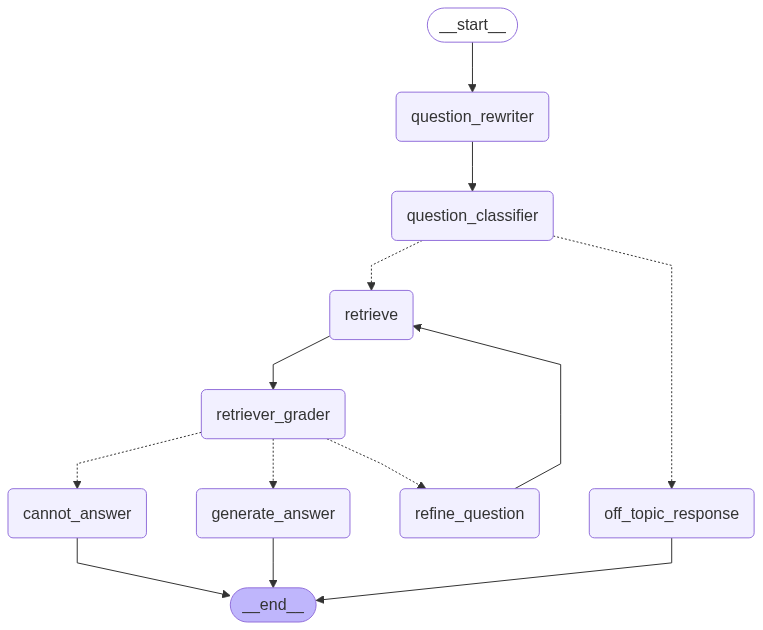

In [78]:
workflow = StateGraph(AgentState)
workflow.add_node("question_rewriter", question_rewriter)
workflow.add_node("question_classifier", question_classifier)
workflow.add_node("off_topic_response", off_topic_response)
workflow.add_node("retrieve", retrieve)
workflow.add_node("retriever_grader", retriever_grader)
workflow.add_node("generate_answer", generate_answer)
workflow.add_node("refine_question", refine_question)
workflow.add_node("cannot_answer", cannot_answer)

workflow.add_edge("question_rewriter","question_classifier")
workflow.add_conditional_edges(
    "question_classifier",
    on_topic_router,
    {
        "retrieve": "retrieve",
        "off_topic_response": "off_topic_response",
    })
workflow.add_edge("retrieve","retriever_grader")
workflow.add_conditional_edges(
    "retriever_grader",
    proceed_router,
    {
        "generate_answer":"generate_answer",
        "refine_question":"refine_question",
        "cannot_answer":"cannot_answer",
    }
)
workflow.add_edge("refine_question","retrieve")
workflow.add_edge("generate_answer",END)
workflow.add_edge("cannot_answer",END)
workflow.add_edge("off_topic_response",END)
workflow.set_entry_point("question_rewriter")
graph = workflow.compile(checkpointer=checkpointer)
graph
    



In [79]:
from uuid import uuid4


In [87]:

input_data = { "question": HumanMessage(content="How much is Sony a7iv camera")}
id=uuid4()
result = graph.invoke(
    input=input_data, 
    config={
        "configurable":{"thread_id":id}
    })

print()
print(result)
print("\n=======ANSWER==============")
print(result['messages'][-1].content)

Entering question_rewriter with the following state:{'question': HumanMessage(content='How much is Sony a7iv camera', additional_kwargs={}, response_metadata={})}
Entering Question_classifier
question_classifier: on_topic = No
Entering on_topic_router
Routing to off_topic_response
Entering off_topic_response

{'question': HumanMessage(content='How much is Sony a7iv camera', additional_kwargs={}, response_metadata={}), 'messages': [HumanMessage(content='How much is Sony a7iv camera', additional_kwargs={}, response_metadata={}), AIMessage(content="I'm sorry! I cannot answer this question ", additional_kwargs={}, response_metadata={})], 'documents': [], 'on_topic': 'No', 'rephrased_question': 'How much is Sony a7iv camera', 'proceed_to_generate': False}

=======ANSWER==============
I'm sorry! I cannot answer this question 


In [89]:
input_data = {
    "question": HumanMessage(
        content= "why was the brother angry when the fatted calf was killed for his younger brother. Is there any lesson from it"
    )
}

id=uuid4()
result = graph.invoke(
    input=input_data, 
        config={
            "configurable":{"thread_id":id}
        })

print()
print(result)
 

Entering question_rewriter with the following state:{'question': HumanMessage(content='why was the brother angry when the fatted calf was killed for his younger brother. Is there any lesson from it', additional_kwargs={}, response_metadata={})}
Entering Question_classifier
question_classifier: on_topic = Yes
Entering on_topic_router
Routing to retrieve
Entering retrieve
retrieve: Retrieve 3 documents
Entering retrieval_grader
Grading document Luke 15 1. Then drew near unto... Result: Yes
Grading document Psalms 124 1. If it had not be... Result: No
Grading document Psalms 1 1. Blessed is the man... Result: No
retrieval_grader: proceed_to_generate = True
Entering Proceed_router
Routing to generate_answer
Entering generate_answer
generator_answer: Generated response: The elder brother was angry when the fatted calf was killed for his younger brother because he felt it was unfair. Despite his years of loyal service to their father and adherence to his commands, he had never been given suc

In [84]:
result['messages'][-1].content

"The brother was angry because he felt a sense of injustice and resentment. Despite having served his father faithfully for many years and never disobeying his commands, he never received such a grand celebration or reward as the fatted calf to celebrate with his friends. Meanwhile, his younger brother, who squandered his father's wealth on irresponsible living, was given a lavish celebration upon his return. This contrast in treatment made the elder brother feel unappreciated and overlooked, fueling his anger and resentment."

### add node

In [21]:
result

{'question': HumanMessage(content='How much is GH7 camera', additional_kwargs={}, response_metadata={}),
 'messages': [HumanMessage(content='How much is GH7 camera', additional_kwargs={}, response_metadata={}),
  AIMessage(content="I'm sorry! I cannot answer this question ", additional_kwargs={}, response_metadata={})],
 'documents': [],
 'on_topic': 'No',
 'rephrased_question': 'How much is GH7 camera',
 'proceed_to_generate': False}